In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                  # convert images to PyTorch tensors
    transforms.Normalize((0.5,),(0.5,))     # normalize the tensor
])

In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=False,
    transform=transform
)

# splite 10% of the training data for validation
num_train = len(train_data)
num_val = int(.1 * num_train)
train_data,val_data = random_split(train_data, [num_train - num_val, num_val])

batch_size = 32
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
print('Data is loaded and ready!')

Data is loaded and ready!


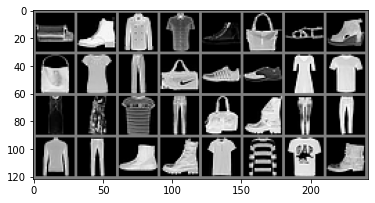

Labels: Bag Ankle boot Coat Shirt Sneaker Bag Sandal Sandal Bag T-shirt/top Trouser Bag Sneaker Sneaker Dress T-shirt/top Dress Dress T-shirt/top Trouser Bag Ankle boot Trouser Trouser Pullover Trouser Ankle boot Ankle boot T-shirt/top Pullover T-shirt/top Ankle boot


In [4]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# function to show an image
def imshow(img):
    img = img * .5 + .5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

In [5]:
class FashionCNN(nn.Module):
    # init the convolutional layers, pooling layer, linear layers, and dropout layer
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(.5)

    # forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# create an instance of the CNN
model = FashionCNN()
print(model)

# loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    train_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # calculate loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)

    # print training statistics
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss: .6f}')


Epoch: 1 	Training Loss:  0.930992
Epoch: 2 	Training Loss:  0.577105
Epoch: 3 	Training Loss:  0.500312
Epoch: 4 	Training Loss:  0.461016
Epoch: 5 	Training Loss:  0.433030
Epoch: 6 	Training Loss:  0.412639
Epoch: 7 	Training Loss:  0.394046
Epoch: 8 	Training Loss:  0.382502
Epoch: 9 	Training Loss:  0.373547
Epoch: 10 	Training Loss:  0.366571
Epoch: 11 	Training Loss:  0.355735
Epoch: 12 	Training Loss:  0.347625
Epoch: 13 	Training Loss:  0.340160
Epoch: 14 	Training Loss:  0.336675
Epoch: 15 	Training Loss:  0.330160
Epoch: 16 	Training Loss:  0.324028
Epoch: 17 	Training Loss:  0.319488
Epoch: 18 	Training Loss:  0.314193
Epoch: 19 	Training Loss:  0.308584
Epoch: 20 	Training Loss:  0.303387


Accuracy on the validation set: 90.72%


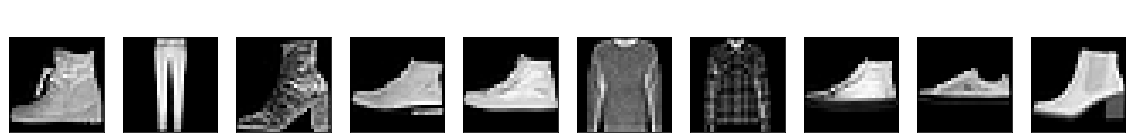

In [8]:
# evaluate the model
model.eval()

# init variable for calculation
correct = 0
total = 0

# set up visualization values
images_to_show = 10
fig = plt.figure(figsize=(20,3))

with torch.no_grad():
    for i, (data, target) in enumerate(val_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # visualize the images and predictions
        if i < images_to_show:
            ax = fig.add_subplot(1, images_to_show, i + 1, xticks=[], yticks=[])
            # convert image to diplayable format
            img = data.cpu().data[i].numpy()
            # remove the channel dimension
            img = img.squeeze()
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[target[i]]}")
            ax.title.set_color('white')

# calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy:.2f}%')
plt.show()
